# Total 106-121

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from catboost import Pool, CatBoostRegressor, cv
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('W:\COVID19\std_inz106_121.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_106to121']
X = df.loc[:, ~df.columns.isin(['std_inz_106to121', 'eastwest'])]
print("Number of features: ", len(X.columns))

Number of features:  163


# First CatBoost Model with 162 features

In [4]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9990659721495803


In [18]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  1.0441548173827364


# SHAP VAlues

In [6]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


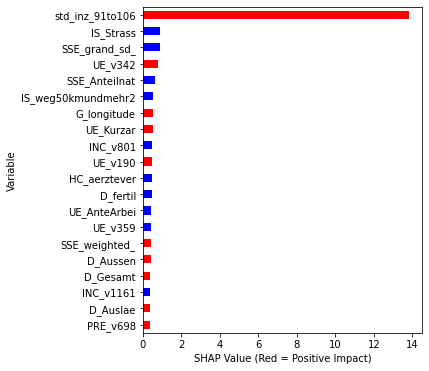

In [7]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

# Second CatBoost model with 20 most important features

In [8]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [9]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9958684749262208


In [20]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  2.1960396639534396


# Compare top 10 features of both Models

In [11]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_91to106', 'IS_Strass', 'SSE_grand_sd_', 'UE_v342', 'SSE_Anteilnat', 'IS_weg50kmundmehr2', 'G_longitude', 'UE_Kurzar', 'INC_v801', 'UE_v190'] 

 10 most important features from model with top20 features: 
 ['std_inz_91to106', 'IS_Strass', 'UE_v359', 'G_longitude', 'SSE_grand_sd_', 'UE_v342', 'UE_v190', 'INC_v801', 'HC_aerztever', 'D_Aussen']


In [12]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_91to106
IS_Strass
SSE_grand_sd_
UE_v342
G_longitude
INC_v801
UE_v190


# Hold out validation of the second model

In [13]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [14]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9976127852739755
Mean R2 of linReg_modesl with top20 features:  0.5813737812517442
Mean RMSE of CatBoost_models on test sets with top20 features:  23.124433340015486
Mean R2 of CatBoost_models on test sets with top20 features: 0.5514311568397468


# descriptives of top20 features

In [15]:
X[top20feature].describe()

,std_inz_91to106,IS_Strass,SSE_grand_sd_,UE_v342,SSE_Anteilnat,IS_weg50kmundmehr2,G_longitude,UE_Kurzar,INC_v801,UE_v190,HC_aerztever,D_fertil,UE_AnteArbei,UE_v359,SSE_weighted_,D_Aussen,D_Gesamt,INC_v1161,D_Auslae,PRE_v698
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,79.007408,491.092926,0.597951,3.798502,5.101742,11.484290,9.866996,0.752618,2846.079834,11.710718,61.357845,1.632219,22.971313,68.926407,0.676074,4.806734,5.103242,35.613968,10.034920,32.458591
std,72.684265,87.669609,0.373193,3.631349,3.710643,3.481254,2.026269,1.440882,926.153870,3.008996,26.108397,0.134031,4.190943,11.196052,0.382720,6.630641,4.276379,15.809457,5.149193,8.857037
min,3.607589,275.799988,0.099060,-8.500000,0.900000,4.900000,6.083333,0.000000,28.000000,4.600000,8.400000,1.060000,14.500000,27.500000,0.143572,-13.900000,-14.000000,16.000000,1.900000,0.000000
25%,34.004898,431.399994,0.368171,1.700000,2.700000,9.000000,8.216666,0.000000,2706.000000,10.600000,44.700001,1.560000,19.500000,62.099998,0.421747,1.500000,2.500000,26.799999,6.200000,26.600000
50%,56.944515,476.399994,0.491239,4.200000,4.300000,10.800000,9.766666,0.300000,3052.000000,12.400000,52.900002,1.650000,22.700001,70.000000,0.583280,3.700000,5.100000,31.400000,9.200000,31.700001
75%,107.506599,545.000000,0.715293,6.200000,6.300000,13.300000,11.416667,0.900000,3329.000000,13.600000,71.099998,1.720000,25.900000,76.699997,0.811219,6.000000,7.500000,38.799999,13.100000,38.200001
max,721.384521,803.599976,3.336848,18.100000,34.000000,24.200001,14.983334,19.600000,4855.000000,20.200001,164.899994,1.940000,34.700001,95.099998,3.392816,65.900002,21.299999,178.800003,35.000000,57.900002


In [16]:
pd.DataFrame(Y).describe()

,std_inz_106to121
count,401.000000
mean,35.316822
std,34.207966
min,0.000000
25%,11.892441
50%,25.522655
75%,47.308884
max,223.532379
